In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

In [3]:
import data
import utils

In [4]:
readerTypes = [data.CacuData, data.FccPmData, data.SuperconductivityData, data.GarmentProductivityData]
targets = ['ViolentCrimesPerPop', 'PM', 'critical_temp', 'actual_productivity']

In [5]:
!mkdir -p models_clean_randgroup

In [6]:
def get_group_constraints(groups):
    interaction_constraints = []
    i=0
    for g in groups:
        interaction_constraints.append(list(range(i, i+len(g))))
        i += len(g)
    return interaction_constraints

In [9]:
mse_collector = {}

for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)

    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}
    
    print("Calculating full model mse...")
    trainData = utils.TrainingData(reader, target, columns=cols)
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    data_mse['base_mse'] = evaluator.base_mse
    data_mse['features_e'] = {'ngroups': 1, 'mse':new_mse}
    
    print("Calculating E^r model mse...")
    booster = trainer.train_model(trainData, {
        'interaction_constraints': [[i] for i in range(len(reader.cols))]
    })
    new_mse = evaluator.get_model_mse(booster)
    data_mse['features_er'] = {'ngroups': len(reader.cols), 'mse':new_mse}
    mse_collector[reader.name] = data_mse
    
    #e_r semantic groups
    if reader.groups is not None:
        print("Calculating semantic group E^r mse...")
        trainData = utils.TrainingData(reader, target, columns=[i for g in reader.groups.values() for i in g])
        booster = trainer.train_model(trainData, {
            'interaction_constraints': get_group_constraints(reader.groups),
        })
        new_mse = evaluator.get_model_mse(booster)
        data_mse['semantic_groups'] = {'ngroups': len(reader.groups), 'mse':new_mse}
    
    for groupsize in [2,3,5,6]:
        np.random.seed(reader.seed)
        ngroups = len(cols)//groupsize
        if ngroups <= 2:
            continue
        mses = []
        print("Calculating random group", groupsize, "E^r mse...")
        for i in tqdm(range(100)):
            feature_perm = np.random.permutation(cols)
            groups = np.array_split(feature_perm, ngroups)[::-1] # array split puts longer groups first, lets switch the order
            trainData = utils.TrainingData(reader, target, columns=[i for g in groups for i in g])
            booster = trainer.train_model(trainData, {
                'interaction_constraints': get_group_constraints(groups),
            })
            new_mse = evaluator.get_model_mse(booster)
            mses.append(new_mse)
        data_mse['random_groups_'+str(groupsize)] = {'ngroups': ngroups, 'mse':np.mean(mses)}
    mse_collector[reader.name] = data_mse

---------
Dataset: Communities and Crime Unnormalized
Calculating full model mse...
Calculating E^r model mse...
Calculating semantic group E^r mse...
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 5 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 6 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: PM2.5 Data of Five Chinese Cities
Calculating full model mse...
Calculating E^r model mse...
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: Superconductivity
Calculating full model mse...
Calculating E^r model mse...
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 5 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 6 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: Productivity Prediction of Garment Employees
Calculating full model mse...
Calculating E^r model mse...
Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
for name, data_mse in mse_collector.items():
    print(name)
    for kind, mse in data_mse.items():
        if kind == "base_mse":
            continue
        print("-", kind, mse['ngroups'], mse['mse']/data_mse['base_mse'])

Communities and Crime Unnormalized
- features_e 1 0.38027166104328924
- features_er 124 0.4062480053720343
- semantic_groups 13 0.3856312415736422
- random_groups_2 62 0.4060129406739165
- random_groups_3 41 0.3997381865503116
- random_groups_5 24 0.3806585189902847
- random_groups_6 20 0.37401852563522353
PM2.5 Data of Five Chinese Cities
- features_e 1 0.6251303299193164
- features_er 14 0.8326940909237712
- random_groups_2 7 0.7823754497255953
- random_groups_3 4 0.7336194592628724
Superconductivity
- features_e 1 0.09774168690569907
- features_er 81 0.17746699215750641
- random_groups_2 40 0.1424491548571722
- random_groups_3 27 0.13269479017036584
- random_groups_5 16 0.12284317077204072
- random_groups_6 13 0.11926090689541963
Productivity Prediction of Garment Employees
- features_e 1 0.5532743667197897
- features_er 14 0.6151372488688107
- random_groups_2 7 0.5861638971292005
- random_groups_3 4 0.5760601387406408


In [11]:
# latex translate dict
ltd = {
    'features_e': 'Base features ($E$)',
    'features_er': 'Base features ($E^r$)',
    'semantic_groups': 'Semantic groups',
    'random_groups_2': 'Random groups (2)',
    'random_groups_3': 'Random groups (3)',
    'random_groups_5': 'Random groups (5)',
    'random_groups_6': 'Random groups (6)',
}
for name, data_mse in mse_collector.items():
    print('\midrule')
    print("\multicolumn{3}{l}{%s}"%name, end="\\\\\n")
    print('\midrule')
    for kind, mse in data_mse.items():
        if kind == "base_mse":
            continue
        print(ltd[kind], mse['ngroups'], "%.4f"%(mse['mse']/data_mse['base_mse']), sep="&", end="\\\\\n")

\midrule
\multicolumn{3}{l}{Communities and Crime Unnormalized}\\
\midrule
Base features ($E$)&1&0.3803\\
Base features ($E^r$)&124&0.4062\\
Semantic groups&13&0.3856\\
Random groups (2)&62&0.4060\\
Random groups (3)&41&0.3997\\
Random groups (5)&24&0.3807\\
Random groups (6)&20&0.3740\\
\midrule
\multicolumn{3}{l}{PM2.5 Data of Five Chinese Cities}\\
\midrule
Base features ($E$)&1&0.6251\\
Base features ($E^r$)&14&0.8327\\
Random groups (2)&7&0.7824\\
Random groups (3)&4&0.7336\\
\midrule
\multicolumn{3}{l}{Superconductivity}\\
\midrule
Base features ($E$)&1&0.0977\\
Base features ($E^r$)&81&0.1775\\
Random groups (2)&40&0.1424\\
Random groups (3)&27&0.1327\\
Random groups (5)&16&0.1228\\
Random groups (6)&13&0.1193\\
\midrule
\multicolumn{3}{l}{Productivity Prediction of Garment Employees}\\
\midrule
Base features ($E$)&1&0.5533\\
Base features ($E^r$)&14&0.6151\\
Random groups (2)&7&0.5862\\
Random groups (3)&4&0.5761\\


In [12]:
labels = list(ltd.keys())
data = [[(mse_dict[l]['mse']/mse_dict['base_mse'] if l in mse_dict else 0) for l in labels] for mse_dict in mse_collector.values()]

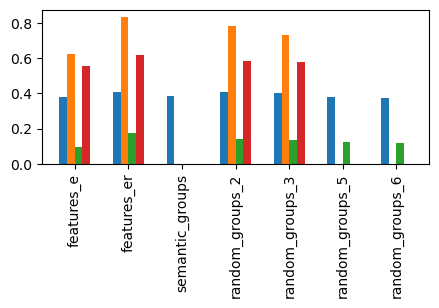

In [13]:
plt.figure(figsize=(5,2))
#labels = ["a","b","c"]
#data = [[1,2,3],[3,2,1],[5,6,7],[1,1,4]]
slack = 3
width = 1/(len(labels)*(len(data)+slack))
pos_0 = np.linspace(0,1,len(data[0])+1)[:-1]
for i,d in enumerate(data):
    plt.bar(pos_0+i*width, d, width=width)
plt.xticks(pos_0+((len(data)-1)*width/2), labels, rotation = 90);

# Contributions

In [36]:
mse_collector = {}

for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)

    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}

    for groupsize in [1,2,3,5,6]:
        np.random.seed(reader.seed)
        ngroups = len(cols)//groupsize
        if ngroups <= 2:
            continue
        mses_e = []
        mses_er = []
        print("Calculating random group", groupsize, "E^r mse...")
        for i in tqdm(range(100)):
            contribs_e = [evaluator.base_mse]
            contribs_er = [evaluator.base_mse]
            feature_perm = np.random.permutation(cols)
            groups = np.array_split(feature_perm, ngroups)[::-1] # array split puts longer groups first, lets switch the order
            groups_sofar = []
            for g in groups:
                groups_sofar.append(g)
                trainData = utils.TrainingData(reader, target, columns=[i for g in groups_sofar for i in g])
                
                booster = trainer.train_model(trainData)
                new_mse = evaluator.get_model_mse(booster)
                contribs_e.append(new_mse - np.sum(contribs_e))
                
                booster = trainer.train_model(trainData, {
                    'interaction_constraints': get_group_constraints(groups_sofar),
                })
                new_mse = evaluator.get_model_mse(booster)
                contribs_er.append(new_mse - np.sum(contribs_er))
                
                if len(contribs_e) > 5:
                    break
            mses_e.append(contribs_e)
            mses_er.append(contribs_er)
        data_mse['random_groups_'+str(groupsize)] = {
            'ngroups': ngroups,
            'mses_e':np.array(mses_e).mean(axis=0),
            'mses_er':np.array(mses_er).mean(axis=0),
            'base_mse':evaluator.base_mse,
        }
    mse_collector[reader.name] = data_mse

---------
Dataset: Communities and Crime Unnormalized
Calculating random group 1 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 5 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 6 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: PM2.5 Data of Five Chinese Cities
Calculating random group 1 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: Superconductivity
Calculating random group 1 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 5 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 6 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

---------
Dataset: Productivity Prediction of Garment Employees
Calculating random group 1 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 2 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating random group 3 E^r mse...


  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
for name, group_setups in mse_collector.items():
    print(name)
    for group, mse_info in group_setups.items():
        print(group)
        print(mse_info['mses_e']/mse_info['base_mse'])
        print(mse_info['mses_er']/mse_info['base_mse'])

Communities and Crime Unnormalized
random_groups_1
[ 1.         -0.13581962 -0.08875594 -0.06440981 -0.06515439 -0.04183157]
[ 1.         -0.13581962 -0.07642613 -0.04481189 -0.04739945 -0.0311251 ]
random_groups_2
[ 1.         -0.22457556 -0.12956155 -0.07881013 -0.04517915 -0.02978859]
[ 1.         -0.22457556 -0.09316917 -0.06551522 -0.03657607 -0.02333432]
random_groups_3
[ 1.         -0.28898537 -0.14396553 -0.06835585 -0.03172062 -0.02056061]
[ 1.         -0.28898537 -0.11219175 -0.05635408 -0.02855884 -0.02293215]
random_groups_5
[ 1.         -0.39597951 -0.1119512  -0.04566263 -0.02381191 -0.01540892]
[ 1.         -0.39597951 -0.08902798 -0.03812489 -0.01701975 -0.01808468]
random_groups_6
[ 1.         -0.43268542 -0.10032866 -0.03642931 -0.01943242 -0.01332475]
[ 1.         -0.43268542 -0.07983357 -0.0371828  -0.01468369 -0.01199517]
PM2.5 Data of Five Chinese Cities
random_groups_1
[ 1.00000000e+00 -7.18138161e-04 -2.94985703e-02 -3.70319403e-02
 -5.12673413e-02 -5.06445057e-

In [45]:
# latex translate dict
ltd = {
    'random_groups_1': 'Individual features',
    'random_groups_2': 'Random groups of size 2',
    'random_groups_3': 'Random groups of size 3',
    'random_groups_5': 'Random groups of size 5',
    'random_groups_6': 'Random groups of size 6',
}
print("Grouping", *["$\phi_%d$"%i for i in range(1,6)], sep="&", end="\\\\\n")
for name, group_setups in mse_collector.items():
    print('\midrule')
    print("\multicolumn{6}{l}{%s}"%name, end="\\\\\n")
    print('\midrule')
    for group, mse_info in group_setups.items():
        print(ltd[group]+" ($E$)", *["%.4f"%f for f in mse_info['mses_e'][1:]/mse_info['base_mse']], sep=" & ", end="\\\\\n")
        print(ltd[group]+" ($E^r$)", *["%.4f"%f for f in mse_info['mses_er'][1:]/mse_info['base_mse']], sep=" & ", end="\\\\\n")

Grouping&$\phi_1$&$\phi_2$&$\phi_3$&$\phi_4$&$\phi_5$\\
\midrule
\multicolumn{6}{l}{Communities and Crime Unnormalized}\\
\midrule
Individual features ($E$) & -0.1358 & -0.0888 & -0.0644 & -0.0652 & -0.0418\\
Individual features ($E^r$) & -0.1358 & -0.0764 & -0.0448 & -0.0474 & -0.0311\\
Random groups of size 2 ($E$) & -0.2246 & -0.1296 & -0.0788 & -0.0452 & -0.0298\\
Random groups of size 2 ($E^r$) & -0.2246 & -0.0932 & -0.0655 & -0.0366 & -0.0233\\
Random groups of size 3 ($E$) & -0.2890 & -0.1440 & -0.0684 & -0.0317 & -0.0206\\
Random groups of size 3 ($E^r$) & -0.2890 & -0.1122 & -0.0564 & -0.0286 & -0.0229\\
Random groups of size 5 ($E$) & -0.3960 & -0.1120 & -0.0457 & -0.0238 & -0.0154\\
Random groups of size 5 ($E^r$) & -0.3960 & -0.0890 & -0.0381 & -0.0170 & -0.0181\\
Random groups of size 6 ($E$) & -0.4327 & -0.1003 & -0.0364 & -0.0194 & -0.0133\\
Random groups of size 6 ($E^r$) & -0.4327 & -0.0798 & -0.0372 & -0.0147 & -0.0120\\
\midrule
\multicolumn{6}{l}{PM2.5 Data of Five 

In [30]:
for name, group_setups in mse_collector.items():
    print(name)
    for group, mse_info in group_setups.items():
        print(group)
        print(mse_info['mses_e']/mse_info['base_mse'])
        print(mse_info['mses_er']/mse_info['base_mse'])

{'random_groups_1': {'ngroups': 124,
  'mses_e': array([306935.62065916, 265247.72746687, 238005.36866657, 218235.70327279,
         198237.50100627, 185397.90328788]),
  'mses_er': array([306935.62065916, 265247.72746687, 241789.82453004, 228035.45950236,
         213486.88135603, 203933.47955831]),
  'base_mse': 306935.6206591561},
 'random_groups_2': {'ngroups': 62,
  'mses_e': array([306935.62065916, 238005.36866657, 198238.31292433, 174048.67654813,
         160181.58577769, 151038.40720213]),
  'mses_er': array([306935.62065916, 238005.36866657, 209408.43270914, 189299.47943938,
         178072.97997092, 170910.84507696]),
  'base_mse': 306935.6206591561},
 'random_groups_3': {'ngroups': 41,
  'mses_e': array([306935.62065916, 218235.70327279, 174047.55452482, 153066.7080982 ,
         143330.52051213, 137019.73700659]),
  'mses_er': array([306935.62065916, 218235.70327279, 183800.05904047, 166502.9846103 ,
         157737.25976544, 150698.56650277]),
  'base_mse': 306935.6206591